In [10]:
!ls /usr/local/cuda*

/usr/local/cuda:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json

/usr/local/cuda-11.2:
bin		   EULA.txt  libnvvp	       nvvm-prev  src
compat		   extras    nsightee_plugins  README	  targets
compute-sanitizer  include   nvml	       samples	  tools
DOCS		   lib64     nvvm	       share	  version.json


In [11]:
!nvidia-smi

Sun Jan 15 16:45:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [74]:
%%writefile heatEq.cu

#include <cuda_runtime_api.h>
#include <math.h>
#include <stdlib.h>
#include <sys/time.h>
#include <cusparse_v2.h>
#include <cublas_v2.h>
#include <thrust/device_ptr.h>
#include <thrust/sequence.h>

#define MEM_PREFETCH

#define gpuCheck(stmt)                                               \
  do {                                                               \
      cudaError_t err = stmt;                                        \
      if (err != cudaSuccess) {                                      \
          printf("ERROR. Failed to run stmt %s\n", #stmt);           \
          break;                                                     \
      }                                                              \
  } while (0)

// Macro to check the cuBLAS status
#define cublasCheck(stmt)                                            \
  do {                                                               \
      cublasStatus_t err = stmt;                                     \
      if (err != CUBLAS_STATUS_SUCCESS) {                            \
          printf("ERROR. Failed to run cuBLAS stmt %s\n", #stmt);    \
          break;                                                     \
      }                                                              \
  } while (0)

// Macro to check the cuSPARSE status
#define cusparseCheck(stmt)                                          \
  do {                                                               \
      cusparseStatus_t err = stmt;                                   \
      if (err != CUSPARSE_STATUS_SUCCESS) {                          \
          printf("ERROR. Failed to run cuSPARSE stmt %s\n", #stmt);  \
          break;                                                     \
      }                                                              \
  } while (0)


struct timeval t_start, t_end;
void cputimer_start(){
  gettimeofday(&t_start, 0);
}
void cputimer_stop(const char* info){
  gettimeofday(&t_end, 0);
  double time = (1000000.0*(t_end.tv_sec-t_start.tv_sec) + t_end.tv_usec-t_start.tv_usec);
  printf("Timing - %s. \t\tElasped %.0f microseconds \n", info, time);
}

// Initialize the sparse matrix needed for the heat time step
// NOTE: this seems to be CSR format
void matrixInit(double* A, int* ArowPtr, int* AcolIndx, int dimX,
    double alpha) {
  // Stencil from the finete difference discretization of the equation
  double stencil[] = { 1, -2, 1 };
  // Variable holding the position to insert a new element
  size_t ptr = 0;
  // Insert a row of zeros at the beginning of the matrix
  ArowPtr[1] = ptr;
  // Fill the non zero entries of the matrix
  for (int i = 1; i < (dimX - 1); ++i) {
    // Insert the elements: A[i][i-1], A[i][i], A[i][i+1]
    for (int k = 0; k < 3; ++k) {
      // Set the value for A[i][i+k-1]
      A[ptr] = stencil[k];
      // Set the column index for A[i][i+k-1]
      AcolIndx[ptr++] = i + k - 1;
    }
    // Set the number of newly added elements
    ArowPtr[i + 1] = ptr;
  }
  // Insert a row of zeros at the end of the matrix
  ArowPtr[dimX] = ptr;
}

int main(int argc, char **argv) {
  int device = 0;            // Device to be used
  int dimX;                  // Dimension of the metal rod
  int nsteps;                // Number of time steps to perform
  double alpha = 0.4;        // Diffusion coefficient
  double* temp;              // Array to store the final time step
  double* A;                 // Sparse matrix A values in the CSR format
  int* ARowPtr;              // Sparse matrix A row pointers in the CSR format
  int* AColIndx;             // Sparse matrix A col values in the CSR format
  int nzv;                   // Number of non zero values in the sparse matrix
  double* tmp;               // Temporal array of dimX for computations
  size_t bufferSize = 0;     // Buffer size needed by some routines
  void* buffer = nullptr;    // Buffer used by some routines in the libraries
  int concurrentAccessQ = 1;     // Check if concurrent access flag is set
  double zero = 0;           // Zero constant
  double one = 1;            // One constant
  double norm;               // Variable for norm values
  double error;              // Variable for storing the relative error
  double tempLeft = 200.;    // Left heat source applied to the rod
  double tempRight = 300.;   // Right heat source applied to the rod
  cublasHandle_t cublasHandle;      // cuBLAS handle
  cusparseHandle_t cusparseHandle;  // cuSPARSE handle
  cusparseSpMatDescr_t Adescriptor;   // Mat descriptor needed by cuSPARSE
  cusparseDnVecDescr_t tempDescriptor;
  cusparseDnVecDescr_t tmpDescriptor;
  
  // Read the arguments from the command line
  dimX = atoi(argv[1]);
  nsteps = atoi(argv[2]);

  // Print input arguments
  printf("The X dimension of the grid is %d \n", dimX);
  printf("The number of time steps to perform is %d \n", nsteps);

  // Get if the cudaDevAttrConcurrentManagedAccess flag is set
  gpuCheck(cudaDeviceGetAttribute(&concurrentAccessQ, cudaDevAttrConcurrentManagedAccess, device));

  // Calculate the number of non zero values in the sparse matrix. This number
  // is known from the structure of the sparse matrix
  nzv = 3 * dimX - 6;
   
  
  //  sizes of arrays
  size_t temp_size = dimX * sizeof(double);
  size_t tmp_size = temp_size;
  size_t A_size = nzv * sizeof(double);
  size_t  ARowPtr_size = (dimX+1) * sizeof(int);
  size_t AColIndx_size = nzv * sizeof(int);

  //@@ Insert the code to allocate the temp, tmp and the sparse matrix
  //@@ arrays using Unified Memory
  cputimer_start();
  
  gpuCheck( cudaMallocManaged(&temp, temp_size) );
  gpuCheck( cudaMallocManaged(&tmp, tmp_size) );
  gpuCheck( cudaMallocManaged(&A, A_size) );
  gpuCheck( cudaMallocManaged(&ARowPtr, ARowPtr_size) );
  gpuCheck( cudaMallocManaged(&AColIndx, AColIndx_size) );
  
  cputimer_stop("Allocating device memory");


  // Check if concurrentAccessQ is non zero in order to prefetch memory
#ifdef MEM_PREFETCH
  if (concurrentAccessQ) {
    cputimer_start();
    //@@ Insert code to prefetch in Unified Memory asynchronously to CPU
    gpuCheck( cudaMemPrefetchAsync(temp, temp_size, cudaCpuDeviceId) );
    gpuCheck( cudaMemPrefetchAsync(tmp, tmp_size, cudaCpuDeviceId) );
    gpuCheck( cudaMemPrefetchAsync(A, A_size, cudaCpuDeviceId) );
    gpuCheck( cudaMemPrefetchAsync(ARowPtr, ARowPtr_size, cudaCpuDeviceId) );
    gpuCheck( cudaMemPrefetchAsync(AColIndx, AColIndx_size, cudaCpuDeviceId) );
    cputimer_stop("Prefetching GPU memory to the host");
  }
#endif

  // Initialize the sparse matrix
  cputimer_start();
  matrixInit(A, ARowPtr, AColIndx, dimX, alpha);
  cputimer_stop("Initializing the sparse matrix on the host");

  //Initiliaze the boundary conditions for the heat equation
  cputimer_start();
  memset(temp, 0, sizeof(double) * dimX);
  temp[0] = tempLeft;
  temp[dimX - 1] = tempRight;
  cputimer_stop("Initializing memory on the host");

#ifdef MEM_PREFETCH
  if (concurrentAccessQ) {
    cputimer_start();
    //@@ Insert code to prefetch in Unified Memory asynchronously to the GPU
  cudaGetDevice(&device);
  gpuCheck( cudaMemPrefetchAsync(temp, temp_size, device) );
  gpuCheck( cudaMemPrefetchAsync(tmp, tmp_size, device) );
  gpuCheck( cudaMemPrefetchAsync(A, A_size, device) );
  gpuCheck( cudaMemPrefetchAsync(ARowPtr, ARowPtr_size, device) );
  gpuCheck( cudaMemPrefetchAsync(AColIndx, AColIndx_size, device) );

    cputimer_stop("Prefetching GPU memory to the device");
  }
#endif

  //@@ Insert code to create the cuBLAS handle
  cublasCheck( cublasCreate(&cublasHandle) );
  //@@ Insert code to create the cuSPARSE handle
  cusparseCheck( cusparseCreate(&cusparseHandle) );

  //@@ Insert code to set the cuBLAS pointer mode to CUSPARSE_POINTER_MODE_HOST
  cublasSetPointerMode(cublasHandle, CUBLAS_POINTER_MODE_HOST);
  // create the Sparse Mat and Dense Vec  descriptor used by cuSPARSE
  cusparseCreateCsr(&Adescriptor, dimX, dimX, nzv, ARowPtr, AColIndx, A, CUSPARSE_INDEX_32I, CUSPARSE_INDEX_32I, CUSPARSE_INDEX_BASE_ZERO, CUDA_R_64F);
  cusparseCreateDnVec(&tmpDescriptor, dimX, tmp, CUDA_R_64F);
  cusparseCreateDnVec(&tempDescriptor, dimX, temp, CUDA_R_64F);
  

  //@@ Insert code to call cusparse api to get the buffer size needed by the sparse matrix per
  cusparseCheck( cusparseSpMV_bufferSize(cusparseHandle,
                                        CUSPARSE_OPERATION_NON_TRANSPOSE,
                                        &one,
                                        Adescriptor,
                                        tempDescriptor,
                                        &zero,
                                        tmpDescriptor,
                                        CUDA_R_64F,
                                        CUSPARSE_SPMV_ALG_DEFAULT,
                                        &bufferSize)
              );
  //@@ vector (SMPV) CSR routine of cuSPARSE


  //@@ Insert code to allocate the buffer needed by cuSPARSE
  gpuCheck( cudaMalloc(&buffer, bufferSize) );

  // Perform the time step iterations
  for (int it = 0; it < nsteps; ++it) {
    //@@ Insert code to call cusparse api to compute the SMPV (sparse matrix multiplication) for
    //@@ the CSR matrix using cuSPARSE. This calculation corresponds to:
    //@@ tmp = 1 * A * temp + 0 * tmp
  cusparseCheck( cusparseSpMV(cusparseHandle,
                            CUSPARSE_OPERATION_NON_TRANSPOSE,
                            &one,
                            Adescriptor,
                            tempDescriptor,
                            &zero,
                            tmpDescriptor,
                            CUDA_R_64F,
                            CUSPARSE_SPMV_ALG_DEFAULT,
                            buffer)
            );


    //@@ Insert code to call cublas api to compute the axpy routine using cuBLAS.
    //@@ This calculation corresponds to: temp = alpha * tmp + temp
    cublasCheck( cublasDaxpy(cublasHandle, dimX, &alpha, tmp, 1, temp, 1) );
    //@@ Insert code to call cublas api to compute the norm of the vector using cuBLAS
    //@@ This calculation corresponds to: ||temp||
    cublasCheck( cublasDnrm2(cublasHandle, dimX, tmp, 1, &norm) );
    
    // If the norm of A*temp is smaller than 10^-4 exit the loop
    if (norm < 1e-4)
      break;
  }

  // Calculate the exact solution using thrust
  thrust::device_ptr<double> thrustPtr(tmp);
  thrust::sequence(thrustPtr, thrustPtr + dimX, tempLeft,
      (tempRight - tempLeft) / (dimX - 1));

  // Calculate the relative approximation error:
  one = -1;
  //@@ Insert the code to call cublas api to compute the difference between the exact solution
  //@@ and the approximation
  //@@ This calculation corresponds to: tmp = -temp + tmp
    cublasCheck( cublasDaxpy(cublasHandle,dimX, &one, temp, 1, tmp, 1) );
  //@@ Insert the code to call cublas api to compute the norm of the absolute error
  //@@ This calculation corresponds to: || tmp ||
  cublasCheck( cublasDnrm2(cublasHandle,dimX, tmp, 1, &norm) );
  error = norm;
  //@@ Insert the code to call cublas api to compute the norm of temp
  //@@ This calculation corresponds to: || temp ||
  cublasCheck( cublasDnrm2(cublasHandle,dimX, temp, 1, &norm) );
  // Calculate the relative error
  error = error / norm;
  printf("The relative error of the approximation is %f\n", error);
  printf("NZM %d\n", nzv);

  //writing the data to a file 
  //FILE *filePointer;
  //filePointer = fopen("data.txt", "a");

  //fprintf(filePointer, "%i\t", nsteps);
  //fprintf(filePointer, "%f\n", error);

  //fclose(filePointer);

  //@@ Insert the code to destroy the mat descriptor
  cusparseCheck( cusparseDestroySpMat(Adescriptor) );
  cusparseCheck( cusparseDestroyDnVec(tmpDescriptor) );
  cusparseCheck( cusparseDestroyDnVec(tempDescriptor) );
  //@@ Insert the code to destroy the cuSPARSE handle
  cusparseCheck( cusparseDestroy(cusparseHandle) );
  //@@ Insert the code to destroy the cuBLAS handle
  cublasCheck( cublasDestroy(cublasHandle) );


  //@@ Insert the code for deallocating memory
  cudaFree(temp);
  cudaFree(tmp);
  cudaFree(A);
  cudaFree(ARowPtr);
  cudaFree(AColIndx);
  cudaFree(buffer);

  return 0;
}


Overwriting heatEq.cu


In [75]:
!nvcc heatEq.cu -O3 -o heatEq -lm -lcublas -lcusparse 

In [46]:
%%shell 
#!/bin/bash

for nstep in $(seq 100 100 10000); do
    echo "Running with nstep = $nstep"
    ./heatEq 128 $nstep
done

Running with nstep = 100
Running with nstep = 200
Running with nstep = 300
Running with nstep = 400
Running with nstep = 500
Running with nstep = 600
Running with nstep = 700
Running with nstep = 800
Running with nstep = 900
Running with nstep = 1000
Running with nstep = 1100
Running with nstep = 1200
Running with nstep = 1300
Running with nstep = 1400
Running with nstep = 1500
Running with nstep = 1600
Running with nstep = 1700
Running with nstep = 1800
Running with nstep = 1900
Running with nstep = 2000
Running with nstep = 2100
Running with nstep = 2200
Running with nstep = 2300
Running with nstep = 2400
Running with nstep = 2500
Running with nstep = 2600
Running with nstep = 2700
Running with nstep = 2800
Running with nstep = 2900
Running with nstep = 3000
Running with nstep = 3100
Running with nstep = 3200
Running with nstep = 3300
Running with nstep = 3400
Running with nstep = 3500
Running with nstep = 3600
Running with nstep = 3700
Running with nstep = 3800
Running with nstep = 

In [76]:
!nvprof ./heatEq 128 100

The X dimension of the grid is 128 
The number of time steps to perform is 100 
==22298== NVPROF is profiling process 22298, command: ./heatEq 128 100
Timing - Allocating device memory. 		Elasped 421734 microseconds 
Timing - Prefetching GPU memory to the host. 		Elasped 99 microseconds 
Timing - Initializing the sparse matrix on the host. 		Elasped 2 microseconds 
Timing - Initializing memory on the host. 		Elasped 0 microseconds 
Timing - Prefetching GPU memory to the device. 		Elasped 351 microseconds 
The relative error of the approximation is 3.318021
NZM 378
==22298== Profiling application: ./heatEq 128 100
==22298== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   75.79%  9.7129ms       204  47.612us  43.807us  52.767us  void nrm2_kernel<double, double, double, int=0, int=0, int=128>(cublasNrm2Params<double, double>)
                   12.58%  1.6127ms       100  16.127us  16.032us  16.864us  _ZN8cusparse21loa

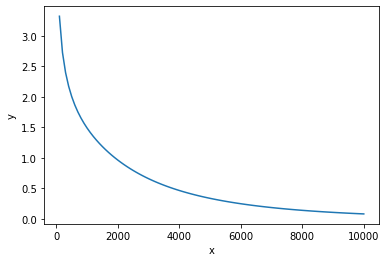

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the text file into a pandas DataFrame
data = pd.read_csv("data.txt", sep="\t", header=None, names=["x", "y"])

# Plot the data using matplotlib
plt.plot(data["x"], data["y"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()
